In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
import tensorflow as tf
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')


# Set the path to the root directory
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(path)


# Load multiple prediction files
df1 = pd.read_csv(path + '/data/predictions/BS_rolling.csv')
df2 = pd.read_csv(path + '/data/predictions/BS_garch.csv')
df3 = pd.read_csv(path + '/data/predictions/BS_IV_avg.csv')
df4 = pd.read_csv(path + '/data/predictions/heston.csv')
df5 = pd.read_csv(path + '/data/predictions/56 All re-run.csv')

print(len(df1[df1["TTM"]==0]), " is the number of TTM = 0 in df1")
print(len(df2[df2["TTM"]==0]), " is the number of TTM = 0 in df2")
print(len(df3[df3["TTM"]==0]), " is the number of TTM = 0 in df3")
print(len(df4[df4["TTM"]==0]), " is the number of TTM = 0 in df4")
print(len(df5[df5["TTM"]==0]), " is the number of TTM = 0 in df5")


# Filter out TTM = 0
df1 = df1[df1["TTM"] > 0]
df2 = df2[df2["TTM"] > 0]
df3 = df3[df3["TTM"] > 0]
df4 = df4[df4["TTM"] > 0]
df5 = df5[df5["TTM"] > 0]

# Drop column "Expire_date" in df4
df4 = df4.drop(columns=["Expire_date"])


# Filter all to only include dates after 2015-01-01
df1 = df1[df1["Quote_date"] >= "2015-01-01"]
df2 = df2[df2["Quote_date"] >= "2015-01-01"]
df3 = df3[df3["Quote_date"] >= "2015-01-01"]
df4 = df4[df4["Quote_date"] >= "2015-01-01"]
df5 = df5[df5["Quote_date"] >= "2015-01-01"]


# Print the first and last Quote_date for each dataframe
print("First Quote_date for df1: ", df1["Quote_date"].min())
print("Last Quote_date for df1: ", df1["Quote_date"].max())
print("First Quote_date for df2: ", df2["Quote_date"].min())
print("Last Quote_date for df2: ", df2["Quote_date"].max())
print("First Quote_date for df3: ", df3["Quote_date"].min())
print("Last Quote_date for df3: ", df3["Quote_date"].max())
print("First Quote_date for df4: ", df4["Quote_date"].min())
print("Last Quote_date for df4: ", df4["Quote_date"].max())
print("First Quote_date for df5: ", df5["Quote_date"].min())
print("Last Quote_date for df5: ", df5["Quote_date"].max())


# Print the length of each dataframe
print("Length of df1: ", len(df1))
print("Length of df2: ", len(df2))
print("Length of df3: ", len(df3))
print("Length of df4: ", len(df4))
print("Length of df5: ", len(df5))



df1 = df1.rename(columns={"BS": "Rolling"})
df2 = df2.rename(columns={"BS": "GARCH"})
df3 = df3.rename(columns={"BS": "IV"})
df4 = df4.rename(columns={"Heston_price": "Heston"})
df5 = df5.rename(columns={"Prediction": "Main"})


241594  is the number of TTM = 0 in df1
241965  is the number of TTM = 0 in df2
241965  is the number of TTM = 0 in df3
180458  is the number of TTM = 0 in df4
217047  is the number of TTM = 0 in df5
First Quote_date for df1:  2015-01-02
Last Quote_date for df1:  2022-12-30
First Quote_date for df2:  2015-01-02
Last Quote_date for df2:  2022-12-30
First Quote_date for df3:  2015-01-02
Last Quote_date for df3:  2022-12-30
First Quote_date for df4:  2015-01-02
Last Quote_date for df4:  2022-12-30
First Quote_date for df5:  2015-01-02
Last Quote_date for df5:  2022-12-30
Length of df1:  10135869
Length of df2:  10135869
Length of df3:  10135869
Length of df4:  9970921
Length of df5:  10135869


In [88]:
# Merge the dataframes on "Quote_date", "TTM" and "Strike"
df = pd.merge(df1, df2[["Quote_date", "TTM", "Strike", "GARCH"]], on=["Quote_date", "TTM", "Strike"])
df = pd.merge(df, df3[["Quote_date", "TTM", "Strike", "IV"]], on=["Quote_date", "TTM", "Strike"])
df = pd.merge(df, df4[["Quote_date", "TTM", "Strike", "Heston"]], on=["Quote_date", "TTM", "Strike"])
df = pd.merge(df, df5[["Quote_date", "TTM", "Strike", "Main"]], on=["Quote_date", "TTM", "Strike"])

# Only keep the columns we need
df = df[["Quote_date", "TTM", "Strike", "Underlying_last", "Price", "Rolling", "GARCH", "IV", "Heston", "Main"]]

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Quote_date', 'Expire_date', 'Price',
       'Underlying_last', 'Strike', 'TTM', 'R', 'Moneyness', 'Volatility',
       'Rolling', 'GARCH', 'IV', 'Heston', 'Main'],
      dtype='object')


In [89]:
df_read = df.copy()

,Quote_date,TTM,Strike,Underlying_last,Price,Rolling,GARCH,IV,Heston,Main
2648422,2020-11-17,213,3825.0,3609.88,106.155,1.387341e+02,1.210731e+02,147.751902,172.130034,123.330345
1795705,2019-06-11,556,2725.0,2885.71,326.105,3.470540e+02,3.833909e+02,574.686201,312.069713,333.539980
3570898,2022-01-26,155,4300.0,4347.26,285.650,2.066997e+02,2.427364e+02,363.855010,261.645960,291.335500
1246488,2018-06-04,564,3125.0,2746.86,51.305,5.945029e+01,9.511209e+01,165.122481,67.491614,51.467743
2412424,2020-06-25,267,2415.0,3083.39,741.995,7.176117e+02,7.221696e+02,737.437333,736.804632,704.684940
1878457,2019-08-08,327,2925.0,2938.68,179.400,1.841433e+02,2.627827e+02,380.107217,186.705835,180.608500
537147,2016-07-08,175,1950.0,2129.38,206.105,2.120804e+02,2.144893e+02,206.419763,201.600251,218.108520
1850274,2019-07-19,256,2700.0,2976.86,350.445,3.200490e+02,3.200763e+02,391.154072,327.490306,352.758420
4101880,2022-09-07,100,4290.0,3980.02,61.050,6.174675e+01,4.388804e+01,138.131966,74.238512,34.398950
95151,2015-04-14,93,1210.0,2095.95,877.005,8.860117e+02,8.860117e+02,886.011661,879.352078,879.167240


Number of rows dropped:  0


In [103]:
df = df_read.copy()

### Params

In [104]:
base = 150

# Overall RMSE

In [105]:
# Print the RMSE for each model
print("RMSE for Rolling: ", np.sqrt(mean_squared_error(df["Rolling"], df["Price"])))
print("RMSE for GARCH: ", np.sqrt(mean_squared_error(df["GARCH"], df["Price"])))
print("RMSE for IV: ", np.sqrt(mean_squared_error(df["IV"], df["Price"])))
print("RMSE for Heston: ", np.sqrt(mean_squared_error(df["Heston"], df["Price"])))
print("RMSE for Main model: ", np.sqrt(mean_squared_error(df["Main"], df["Price"])))

RMSE for Rolling:  47.36514646523884
RMSE for GARCH:  48.114283523929124
RMSE for IV:  63.9209478583035
RMSE for Heston:  19.469355466973767
RMSE for Main model:  20.84587393627621


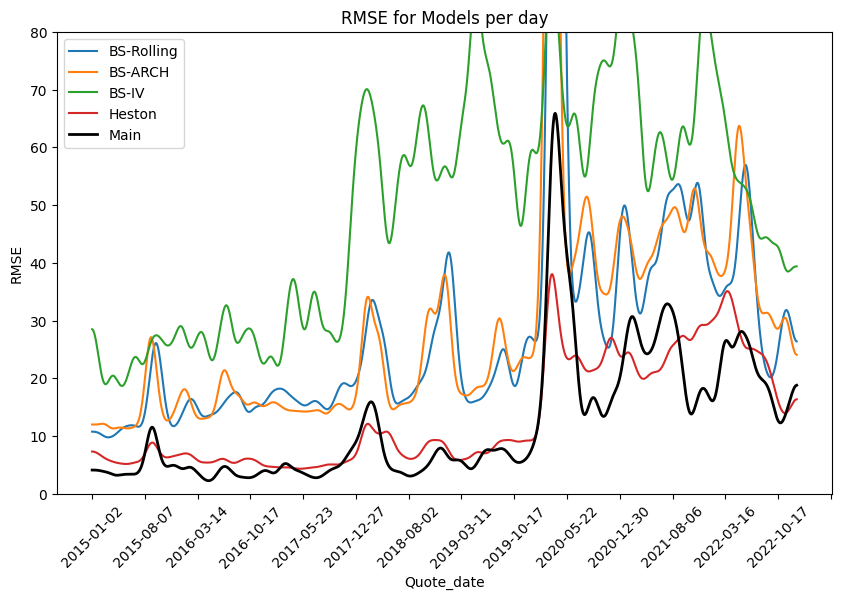

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error

# Define a function to calculate RMSE
def calculate_rmse(group):
    rmse_model_1 = np.sqrt(mean_squared_error(group["Price"], group["Rolling"]))
    rmse_model_2 = np.sqrt(mean_squared_error(group["Price"], group["GARCH"]))
    rmse_model_3 = np.sqrt(mean_squared_error(group["Price"], group["IV"]))
    rmse_model_4 = np.sqrt(mean_squared_error(group["Price"], group["Heston"]))
    rmse_model_5 = np.sqrt(mean_squared_error(group["Price"], group["Main"]))
    return pd.Series({"RMSE_Model_1": rmse_model_1, "RMSE_Model_2": rmse_model_2, "RMSE_Model_3": rmse_model_3, "RMSE_Model_4": rmse_model_4, "RMSE_Model_5": rmse_model_5})

# Group data by Quote_date and calculate RMSE for each group
rmse_df = df.groupby("Quote_date").apply(calculate_rmse).reset_index()


# Smooth the RMSE values by using gaussian filter
sigma = 15
rmse_df["RMSE_Model_1"] = gaussian_filter1d(rmse_df["RMSE_Model_1"], sigma=sigma)
rmse_df["RMSE_Model_2"] = gaussian_filter1d(rmse_df["RMSE_Model_2"], sigma=sigma)
rmse_df["RMSE_Model_3"] = gaussian_filter1d(rmse_df["RMSE_Model_3"], sigma=sigma)
rmse_df["RMSE_Model_4"] = gaussian_filter1d(rmse_df["RMSE_Model_4"], sigma=sigma)
rmse_df["RMSE_Model_5"] = gaussian_filter1d(rmse_df["RMSE_Model_5"], sigma=sigma)


# Plot the RMSE values for each model
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_1", label="BS-Rolling", ax=ax)
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_2", label="BS-ARCH", ax=ax)
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_3", label="BS-IV", ax=ax)
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_4", label="Heston", ax=ax)
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_5", label="Main", ax=ax, color="black", linewidth=2)


# Set the interval for x-axis labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=base))

# Set y limit between 0 and 100
ax.set_ylim(0, 80)

plt.xlabel("Quote_date")
plt.ylabel("RMSE")
plt.title("RMSE for Models per day")
plt.legend()
plt.xticks(rotation=45)
plt.show()


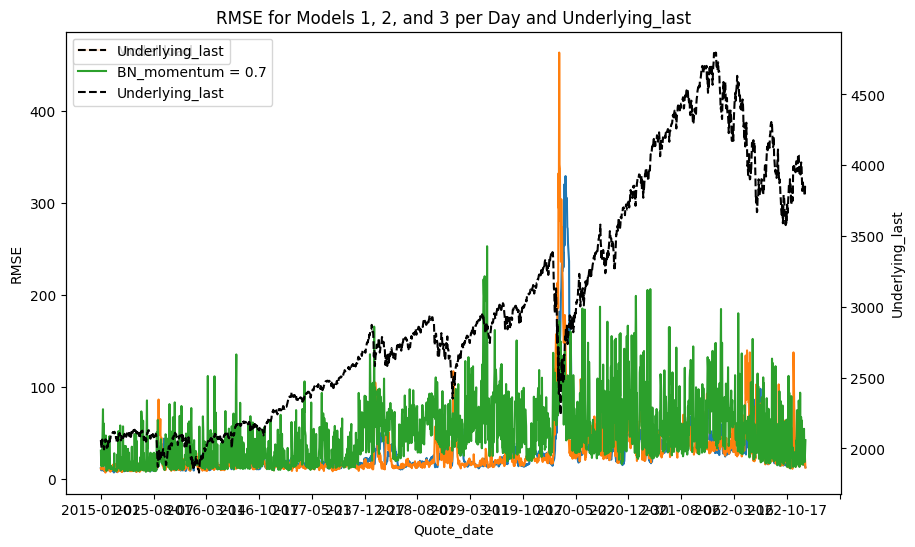

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error


# Group data by Quote_date and calculate RMSE for each group
rmse_df = df.groupby("Quote_date").apply(calculate_rmse).reset_index()

# Create a new column in rmse_df with the mean Underlying_last value for each Quote_date
rmse_df["Underlying_last"] = df.groupby("Quote_date")["Underlying_last"].mean().values



# Plot the RMSE values for each model
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_1", label="", ax=ax)
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_2", label="Model load", ax=ax)
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_3", label="BN_momentum = 0.7", ax=ax)

# Set the interval for x-axis labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=base))

# Create a second y-axis for Underlying_last values
ax2 = ax.twinx()
sns.lineplot(data=rmse_df, x="Quote_date", y="Underlying_last", label="Underlying_last", color="black", ax=ax2, linestyle="--")

# Set the labels and title
ax.set_xlabel("Quote_date")
ax.set_ylabel("RMSE")
ax2.set_ylabel("Underlying_last")
plt.title("RMSE for Models 1, 2, and 3 per Day and Underlying_last")

# Combine the legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="upper left")

plt.xticks(rotation=30)
plt.show()


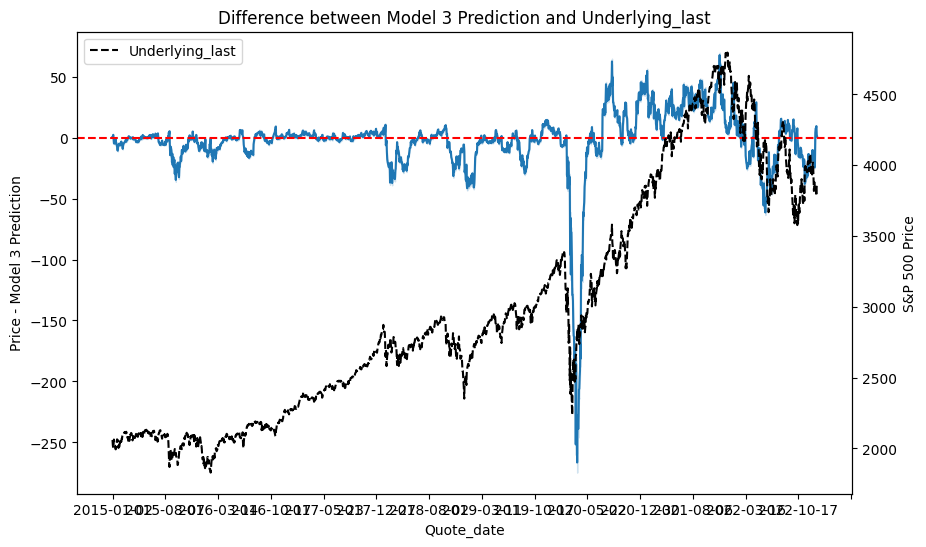

In [108]:
df = df_read.copy()
# Plot the prediction of model 3 minus the actual price value

# New column with the difference between the prediction and the actual value
df["Diff"] = df["Price"] - df["Rolling"]

# Plot the difference
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df, x="Quote_date", y="Diff", ax=ax)

# Set the interval for x-axis labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=base))
plt.ylabel("Price - Model 3 Prediction")

# Add zero line
plt.axhline(y=0, color="red", linestyle="--", label = "Actual Price")

# Adding underlying
df_underlying = df.groupby("Quote_date")["Underlying_last"].mean().reset_index()


# Create a second y-axis for Underlying_last values
ax2 = ax.twinx()
sns.lineplot(data=df_underlying, x="Quote_date", y="Underlying_last", label="Underlying_last", color="black", ax=ax2, linestyle="--")


plt.xlabel("Quote_date")
plt.ylabel("S&P 500 Price")
plt.title("Difference between Model 3 Prediction and Underlying_last")
plt.xticks(rotation=30)
plt.show()

### TTM

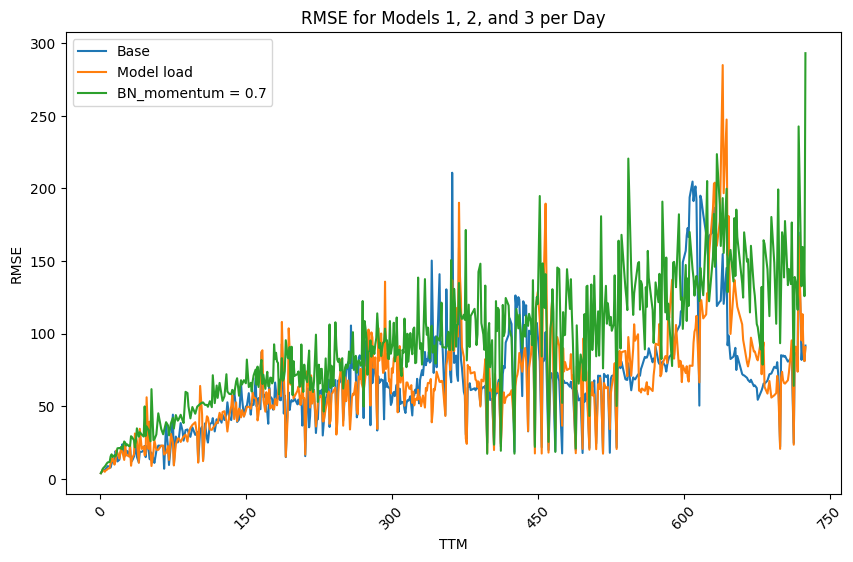

In [109]:
# Group data by Quote_date and calculate RMSE for each group
rmse_df = df.groupby("TTM").apply(calculate_rmse).reset_index()


# Plot the RMSE values for each model
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=rmse_df, x="TTM", y="RMSE_Model_1", label="Base", ax=ax)
sns.lineplot(data=rmse_df, x="TTM", y="RMSE_Model_2", label="Model load", ax=ax)
sns.lineplot(data=rmse_df, x="TTM", y="RMSE_Model_3", label="BN_momentum = 0.7", ax=ax)


# Set the interval for x-axis labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=base))


plt.xlabel("TTM")
plt.ylabel("RMSE")
plt.title("RMSE for Models 1, 2, and 3 per Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

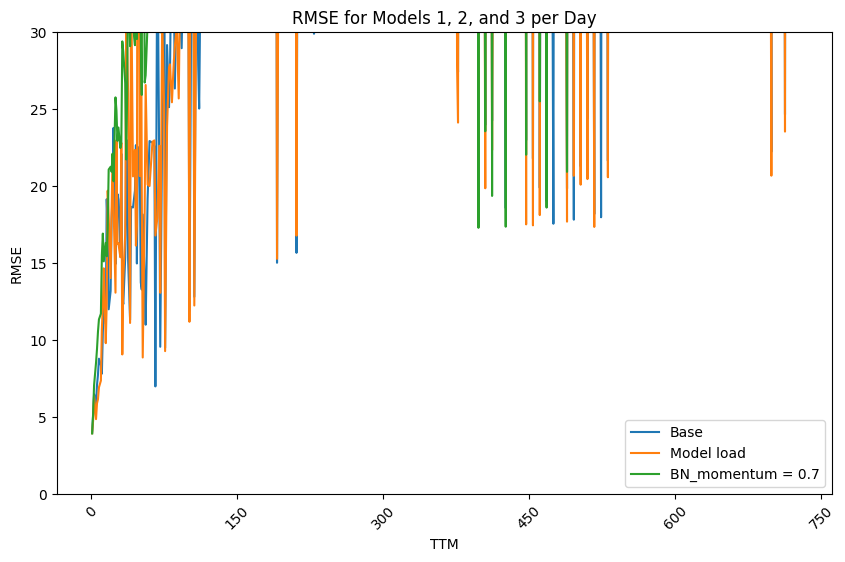

In [110]:
# Group data by Quote_date and calculate RMSE for each group
rmse_df = df.groupby("TTM").apply(calculate_rmse).reset_index()

# Plot the RMSE values for each model
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=rmse_df, x="TTM", y="RMSE_Model_1", label="Base", ax=ax)
sns.lineplot(data=rmse_df, x="TTM", y="RMSE_Model_2", label="Model load", ax=ax)
sns.lineplot(data=rmse_df, x="TTM", y="RMSE_Model_3", label="BN_momentum = 0.7", ax=ax)


# Set the interval for x-axis labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=base))


plt.ylim(0, 30)

plt.xlabel("TTM")
plt.ylabel("RMSE")
plt.title("RMSE for Models 1, 2, and 3 per Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Moneyness

In [111]:
# Add moneyness
df["Moneyness"] = df["Underlying_last"] / df["Strike"]

In [112]:
# Group data by Moneyness and calculate RMSE for each group
rmse_df = df.groupby("Moneyness").apply(calculate_rmse).reset_index()

# Define the rolling mean window size
window_size = 200

# Apply rolling mean to the RMSE values
rmse_df["RMSE_Model_1_smooth"] = rmse_df["RMSE_Model_1"].rolling(window=window_size).mean()
rmse_df["RMSE_Model_2_smooth"] = rmse_df["RMSE_Model_2"].rolling(window=window_size).mean()
rmse_df["RMSE_Model_3_smooth"] = rmse_df["RMSE_Model_3"].rolling(window=window_size).mean()

# Plot the smoothed RMSE values for each model
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=rmse_df, x="Moneyness", y="RMSE_Model_1_smooth", label="Base", ax=ax)
sns.lineplot(data=rmse_df, x="Moneyness", y="RMSE_Model_2_smooth", label="Model load", ax=ax)
sns.lineplot(data=rmse_df, x="Moneyness", y="RMSE_Model_3_smooth", label="BN_momentum = 0.7", ax=ax)

# Set the interval for x-axis labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.1))

plt.ylim(0,15)

plt.xlabel("Moneyness")
plt.ylabel("Smoothed RMSE")
plt.title("Smoothed RMSE for Models 1, 2, and 3 per Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Tabel

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Assuming df is a DataFrame with the required columns

df_low_money = df[df["Underlying_last"] / df["Strike"] < 0.97]
df_low_money.name = "<0.97"
df_mid_money = df[(df["Underlying_last"] / df["Strike"]).between(0.97, 1.03, inclusive=True)]
df_mid_money.name = "0.97-1.03"
df_high_money = df[df["Underlying_last"] / df["Strike"] > 1.03]
df_high_money.name = ">1.03"

df_table = pd.DataFrame(columns=['Moneyness', 'Maturity', 'Rolling', 'GARCH', 'IV', "Heston", "Main"])
maturity_intervals = [(0, 10), (10, 30), (30, 90), (90, 300), (300, 730)]

for dataframe in [df_low_money, df_mid_money, df_high_money]:
    for start, end in maturity_intervals:
        df_temp = dataframe[(dataframe["TTM"]).between(start, end, inclusive=True)]
        model_1 = np.sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["Rolling"]))
        model_2 = np.sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["GARCH"]))
        model_3 = np.sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["IV"]))
        model_4 = np.sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["Heston"]))
        model_5 = np.sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["Main"]))
        df_table.loc[len(df_table.index)] = [dataframe.name, f"{start}-{end}", model_1, model_2, model_3, model_4, model_5]




# Only provide the first moneyness column, not for the other maturities for that moneyness level
df_table["Moneyness"] = df_table["Moneyness"].where(df_table["Maturity"] == "0-10", "")

# Round the RMSE values to 2 decimal places
df_table = df_table.round(2)

# Write to file
df_table.to_csv('RMSE_benchmark_tabel.csv', encoding='utf-8', index=False)

# Write to latex
with open('RMSE_benchmark_tabel.tex', 'w') as tf:
     tf.write(df_table.to_latex())


# Data analysis

### What's up with TTM = 4?

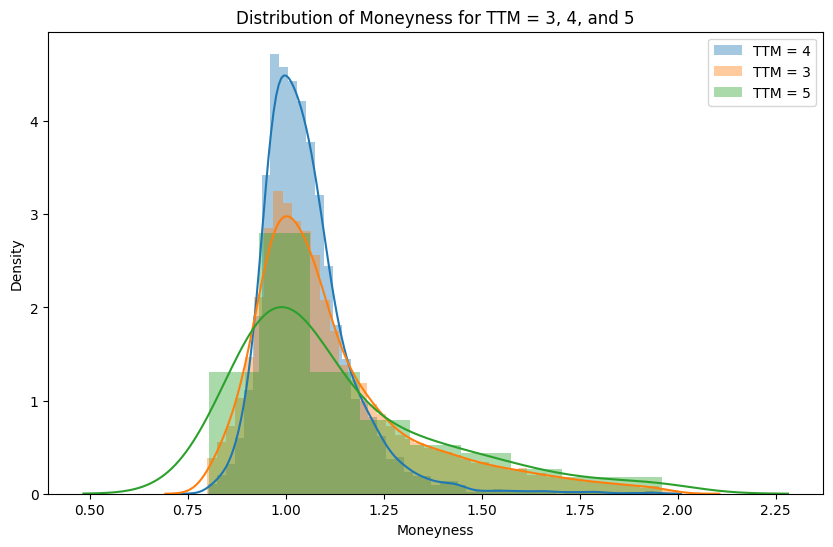

In [ ]:
# Plot distribution of moneyness of TTM = 4 vs TTM = 3 & TTM = 5 for just model 3
fig, ax = plt.subplots(figsize=(10, 6))

sns.distplot(df[df["TTM"] == 4]["Moneyness"], label="TTM = 4", ax=ax)
sns.distplot(df[df["TTM"] == 3]["Moneyness"], label="TTM = 3", ax=ax)
sns.distplot(df[df["TTM"] == 5]["Moneyness"], label="TTM = 5", ax=ax)


plt.xlabel("Moneyness")

plt.title("Distribution of Moneyness for TTM = 3, 4, and 5")
plt.legend()
plt.show()


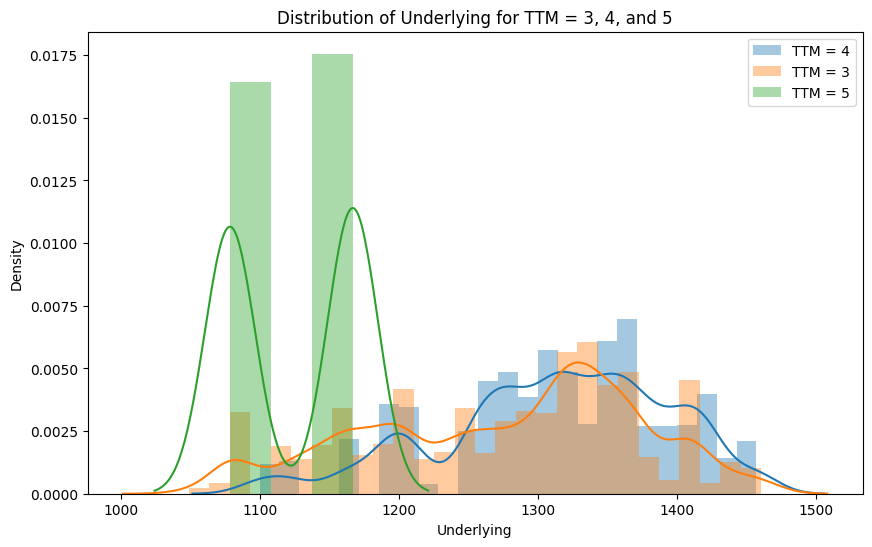

In [ ]:
# Plot distribution of underlying of TTM = 4 vs TTM = 3 & TTM = 5 for just model 3
fig, ax = plt.subplots(figsize=(10, 6))

sns.distplot(df[df["TTM"] == 4]["Underlying_last"], label="TTM = 4", ax=ax)

sns.distplot(df[df["TTM"] == 3]["Underlying_last"], label="TTM = 3", ax=ax)

sns.distplot(df[df["TTM"] == 5]["Underlying_last"], label="TTM = 5", ax=ax)


plt.xlabel("Underlying")

plt.title("Distribution of Underlying for TTM = 3, 4, and 5")
plt.legend()
plt.show()


In [ ]:
# Figure out what is different about the TTM = 4 data
print("TTM = 4")
display(df[df["TTM"] == 4].describe())

print("TTM = 4 or 5")
display(df[df["TTM"].isin([4, 5])].describe())


TTM = 4


,Unnamed: 0.1,Unnamed: 0,Price,Underlying_last,Strike,TTM,R,Moneyness,Volatility,Model 1,Model 2,Model 3,Diff
count,3325.000000,3325.000000,3325.000000,3325.000000,3325.000000,3325.0,3325.000000,3325.000000,3325.000000,3.325000e+03,3325.000000,3325.000000,3325.000000
mean,471999.322105,471999.322105,78.862902,1311.881368,1257.392481,4.0,0.053826,1.053560,0.174986,7.862264e+01,172.920372,291.063306,-212.200403
std,137764.318359,137764.318359,99.144476,81.691685,134.276141,0.0,0.048188,0.118349,0.083554,9.958464e+01,179.530271,328.371377,348.754608
min,207524.000000,207524.000000,0.020000,1099.650000,600.000000,4.0,0.000000,0.802103,0.077042,1.323274e-106,0.000000,0.000000,-1350.996600
25%,364443.000000,364443.000000,1.245000,1260.980000,1175.000000,4.0,0.020000,0.977716,0.115495,1.025701e+00,15.136392,28.761782,-354.087330
50%,464779.000000,464779.000000,43.395000,1316.090000,1265.000000,4.0,0.050000,1.032734,0.148399,4.201569e+01,108.175604,175.679230,-107.922300
75%,592835.000000,592835.000000,119.895000,1367.910000,1350.000000,4.0,0.070000,1.100876,0.224686,1.205914e+02,295.611281,436.235380,16.600000
max,697852.000000,697852.000000,657.000000,1457.090000,1800.000000,4.0,0.300000,1.938417,0.416952,6.570926e+02,685.700509,1369.002900,607.705000


TTM = 4 or 5


,Unnamed: 0.1,Unnamed: 0,Price,Underlying_last,Strike,TTM,R,Moneyness,Volatility,Model 1,Model 2,Model 3,Diff
count,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3.414000e+03,3414.000000,3414.000000,3414.000000
mean,461585.827475,461585.827475,80.077289,1306.983301,1251.635911,4.026069,0.054534,1.055605,0.175140,7.984871e+01,174.639060,294.581717,-214.504428
std,150194.378198,150194.378198,101.440343,86.295257,140.799107,0.159364,0.047997,0.124778,0.083789,1.018708e+02,178.611645,331.743298,354.076106
min,44587.000000,44587.000000,0.020000,1078.340000,550.000000,4.000000,0.000000,0.802103,0.077042,1.323274e-106,0.000000,0.000000,-1350.996600
25%,359532.250000,359532.250000,1.196250,1257.800000,1170.000000,4.000000,0.020000,0.977014,0.110735,9.848131e-01,16.387961,28.940962,-358.716295
50%,454865.500000,454865.500000,43.247500,1315.890000,1265.000000,4.000000,0.050000,1.032750,0.148399,4.198480e+01,113.376400,179.865315,-108.861835
75%,592812.750000,592812.750000,120.925000,1367.910000,1345.000000,4.000000,0.070000,1.102248,0.224686,1.218236e+02,298.968147,436.971300,16.730277
max,697852.000000,697852.000000,657.000000,1457.090000,1800.000000,5.000000,0.300000,1.960618,0.416952,6.570926e+02,685.700509,1369.002900,607.705000


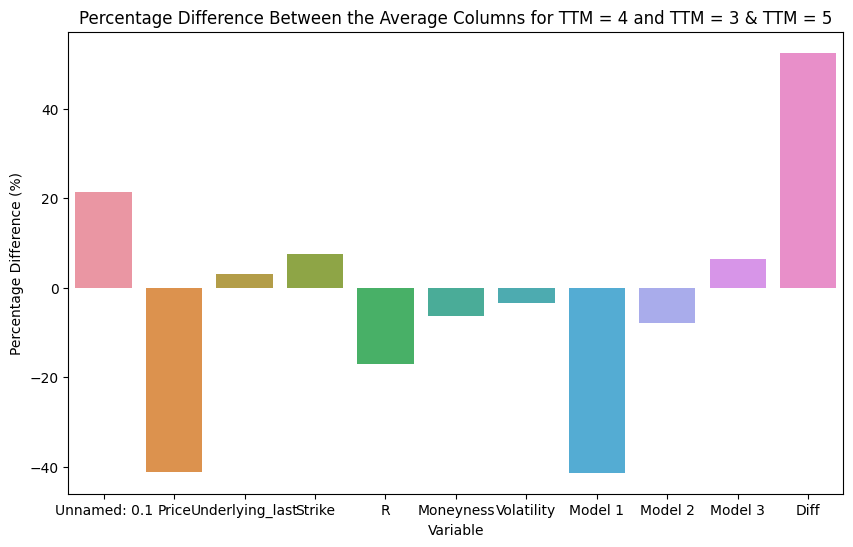

In [ ]:
# Calculate the mean values for each group
df_temp = df[df["TTM"].isin([3, 4, 5])].copy()
df_temp["TTM"] = df_temp["TTM"].replace({3: "3 or 5", 4: "4", 5: "3 or 5"})
df_temp = df_temp.groupby("TTM").mean().reset_index()

# Calculate the percentage difference between the mean values for each variable
mean_ttm_4 = df_temp[df_temp["TTM"] == "4"].drop(["TTM", "Unnamed: 0"], axis=1)
mean_ttm_3_5 = df_temp[df_temp["TTM"] == "3 or 5"].drop(["TTM", "Unnamed: 0"], axis=1)
percentage_diff = 100 * ((mean_ttm_4.values - mean_ttm_3_5.values) / mean_ttm_3_5.values)

# Create a new DataFrame with the percentage difference
percentage_diff_df = pd.DataFrame(percentage_diff, columns=mean_ttm_4.columns)
percentage_diff_df["TTM"] = "Percentage Difference"
percentage_diff_df = percentage_diff_df.melt(id_vars="TTM", var_name="Variable", value_name="Value")

# Plot the percentage difference using a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=percentage_diff_df, x="Variable", y="Value", ax=ax)

plt.xlabel("Variable")
plt.ylabel("Percentage Difference (%)")
plt.title("Percentage Difference Between the Average Columns for TTM = 4 and TTM = 3 & TTM = 5")
plt.show()
